# Convolutional Variational

Following official tensorflow VAE autoencoder tutorial, this one uses a different loss function than what I used in lab1

This notebook demonstrates how to train a Variational Autoencoder (VAE) (1, 2) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb#scrollTo=P-JuIu2N_SQf

In [1]:
## !pip install tensorflow-probability ## this version doesn't work with tf 2.6 so remove it
# ! pip install "tensorflow_probability>=0.14.1, <0.15"
# ! pip install tensorflow --upgrade
# # to generate gifs
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [13]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.data import Dataset
from_tensor_slices = Dataset.from_tensor_slices
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Sequential, Model
import tensorflow_docs.vis.embed as embed


from the tutorial:

Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.


In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
    images = images.reshape( (images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 6000
batch_size = 32
test_size = 10000

In [6]:

train_dataset = (from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

from tutorial 

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [7]:
class CVAE(Model):
    '''Conv variational autoencoder'''
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.__define_encoder_model()
        self.decoder = self.__define_decoder_model()
        
    @tf.function
    def sample(self, epslon=None):
        if epslon is None:
            epslon = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(epslon, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
        epslon = tf.random.normal(shape=mean.shape)
        return epslon * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    # private goes below
    
    def __define_encoder_model(self):
        s = (2,2) # strides
        a = 'relu'
        dense_units = self.latent_dim *2
        
        inputs = Input(shape=(28, 28,1), name='encoder_start')
        x = Conv2D(filters=32, kernel_size=3, strides=s, activation=a)(inputs)
        x = Conv2D(filters=64, kernel_size=3, strides=s,activation=a)(x)
        x = Flatten()(x)
        x = Dense(dense_units)(x)
        return Model(inputs=inputs, outputs=x)
    
    def __define_decoder_model(self):
        inputs = Input(shape=(self.latent_dim,), name='decoder_start')
        x = Dense(units=7*7*32, activation='relu')(inputs)
        x = Reshape(target_shape=(7, 7, 32))(x)
        x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation='relu')(x)
        x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation='relu')(x)        
        # no activation in this one and stride is 1
        x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")(x)
        return Model(inputs=inputs, outputs=x)

from tutorial

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparametrize(mean, logvar)
    x_logit = model.decode(z)
    # need logits and labels to be same shape
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    """ executes one training step, updates the model parameeters and returns the loss."""
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    # how the loss changes with respect to model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [9]:
epochs = 10
latent_dim = 2 
num_examples_to_generate= 16

#keep random vector the same for generation (prediction) so it's easier to see improvment
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
    )
model = CVAE(latent_dim)


In [10]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparametrize(mean, logvar)
    predictions = model.sample(z)
    plt.rcParams['figure.facecolor']="w"
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

In [11]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.57421875, time elapse for current epoch: 7.384901523590088


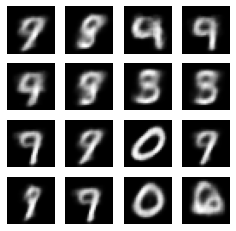

In [14]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [15]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

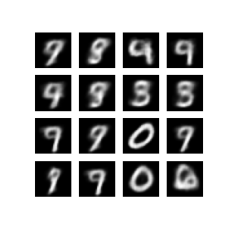

In [16]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [17]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


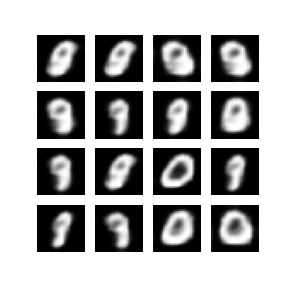

In [18]:
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

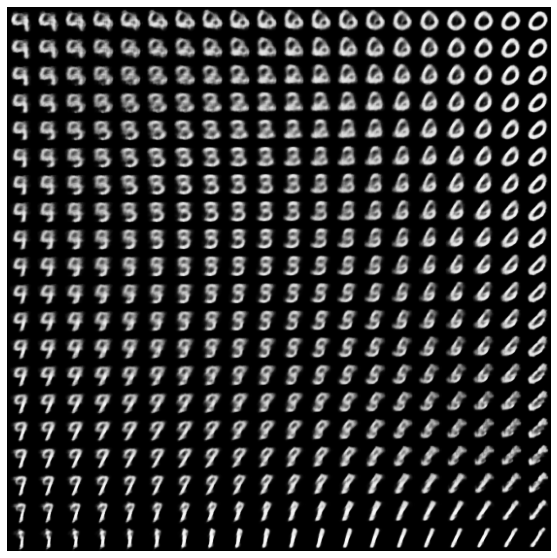

In [19]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()
    

plot_latent_images(model, 20)